In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import h5py
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

In [5]:
df = pd.read_excel("mental_health_chatbot_useful.xlsx")

user_inputs = df["User Input"].fillna("").astype(str).values
bot_responses = df["Bot Response"].fillna("").astype(str).values

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(user_inputs)

sequences = tokenizer.texts_to_sequences(user_inputs)
padded_sequences = pad_sequences(sequences, padding='post')


In [6]:
# Encode bot responses as categorical labels
label_encoder = LabelEncoder()
encoded_responses = label_encoder.fit_transform(bot_responses)

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, encoded_responses, test_size=0.2, random_state=42
)


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=padded_sequences.shape[1]),  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=callbacks)



D:\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.1585 - loss: 2.7133 - val_accuracy: 0.2417 - val_loss: 2.1546 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3708 - loss: 2.1459 - val_accuracy: 0.7583 - val_loss: 1.0081 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7130 - loss: 1.0670 - val_accuracy: 0.8833 - val_loss: 0.4076 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8874 - loss: 0.4090 - val_accuracy: 0.9833 - val_loss: 0.1405 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9249 - loss: 0.2862 - val_accuracy: 0.9833 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9674 - loss: 0.1467 - val_accuracy: 1.0000 - val_loss: 0.0243 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9840 - loss: 0.1119 -

In [8]:
model.save('mentalchatbotfinal.keras')

In [9]:
def chatbot_response(user_input):
    
    seq = tokenizer.texts_to_sequences([user_input])
    padded = pad_sequences(seq, maxlen=padded_sequences.shape[1], padding='post')
    pred = model.predict(padded)
    response_index = np.argmax(pred)
    return label_encoder.inverse_transform([response_index])[0]


In [ ]:
# Test the chatbot
while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        break
    print("Bot:", chatbot_response(user_input))


You: Hello who are you?
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
Bot: That's wonderful to hear! What made your day special?
You: who are you?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Bot: My name is Lily and I am your personal helper!
You: I am feeling sad today
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Bot: That's amazing! What helped you build your confidence?
You: I had a great day today!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Bot: That's wonderful to hear! What made your day special?
You: I'm so stressed with work deadlines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Bot: That sounds overwhelming. Have you considered breaking tasks into smaller steps?
You: I feel like no one understands me.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Bot: That sounds really tough. You're not alone—I'm here to listen.
You: I had a panic attack yesterday.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Bot: That sounds really difficult. Deep breathing and grounding techniques might help.
You: who are you?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [1]:
# Now for the Performance Metrics
from tensorflow.keras.models import load_model

model = load_model('mentalchatbotfinal.keras')

In [11]:
# Get predictions for the test set
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Class labels

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step


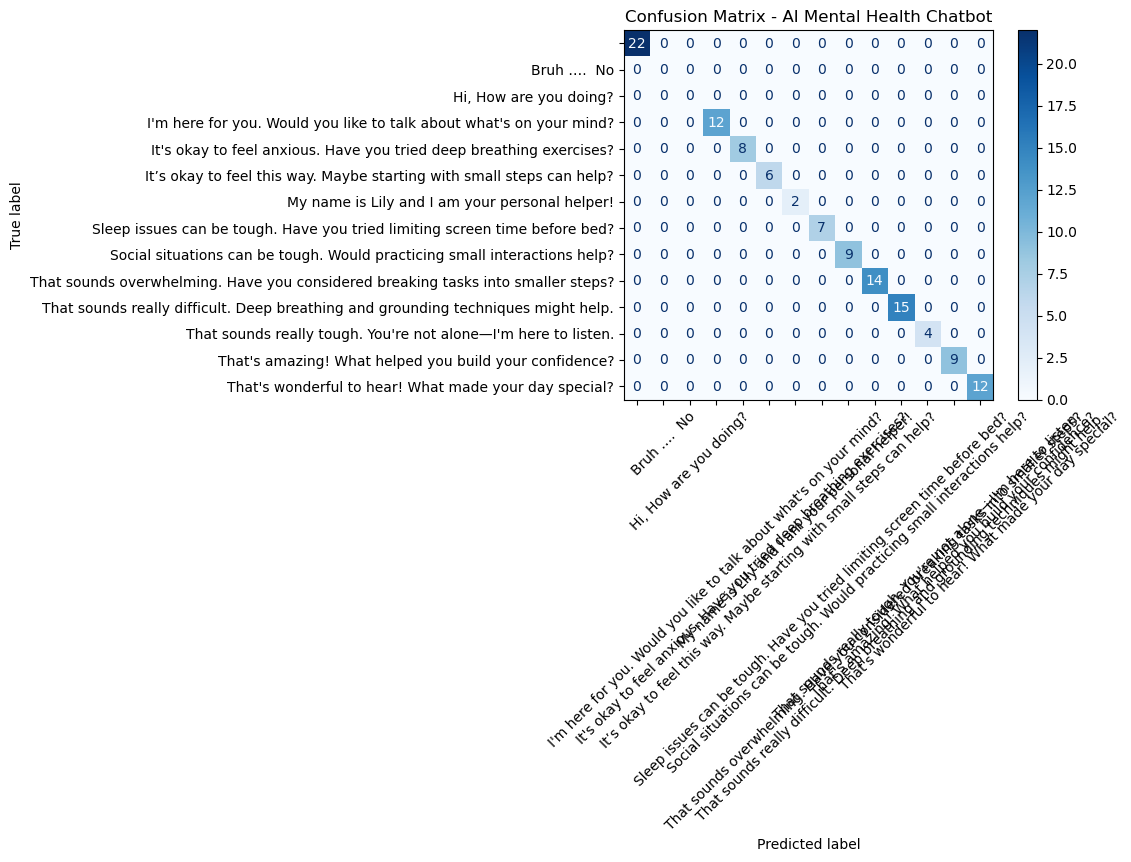

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Force full label display (14 classes)
all_labels = np.arange(len(label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_classes, labels=all_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - AI Mental Health Chatbot")
plt.show()


In [13]:
from sklearn.metrics import classification_report

report = classification_report(
    y_test,
    y_pred_classes,
    labels=all_labels,
    target_names=label_encoder.classes_,
    zero_division=0  # Avoids warnings for classes with no support
)

print("Classification Report:\n")
print(report)

Classification Report:

                                                                                   precision    recall  f1-score   support

                                                                                        1.00      1.00      1.00        22
                                                                      Bruh ….  No       0.00      0.00      0.00         0
                                                           Hi, How are you doing?       0.00      0.00      0.00         0
              I'm here for you. Would you like to talk about what's on your mind?       1.00      1.00      1.00        12
              It's okay to feel anxious. Have you tried deep breathing exercises?       1.00      1.00      1.00         8
            It’s okay to feel this way. Maybe starting with small steps can help?       1.00      1.00      1.00         6
                                   My name is Lily and I am your personal helper!       1.00      1.00      1.00  

In [14]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [10]:
!pip install pydot

  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/b0/5f/1ebfd430df05c4f9e438dd3313c4456eab937d976f6ab8ce81a98f9fb381/pydot-3.0.4-py3-none-any.whl.metadata


In [1]:
from tensorflow.keras.models import load_model

model = load_model('mentalchatbotfinal.keras')

In [4]:
!pip uninstall pydot pydotplus graphviz -y
!pip install pydot graphviz

Found existing installation: pydot 3.0.4
Uninstalling pydot-3.0.4:
  Successfully uninstalled pydot-3.0.4


  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/b0/5f/1ebfd430df05c4f9e438dd3313c4456eab937d976f6ab8ce81a98f9fb381/pydot-3.0.4-py3-none-any.whl.metadata
  Using cached pydot-3.0.4-py3-none-any.whl.metadata (10 kB)
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
Using cached pydot-3.0.4-py3-none-any.whl (35 kB)
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   -------------------------- ------------- 30.7/47.1 kB 325.1 kB/s eta 0:00:01
   ---------------------------------- ----- 41.0/47.1 kB 217.9 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 214.5 kB/s eta 0:00:00


In [5]:
from tensorflow.keras.models import load_model

model = load_model('mentalchatbotfinal.keras')

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'